<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [27]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [28]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [30]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')
    scheduler.step()

Epoch 1: Loss: 1.0033, Train Accuracy: 65.77%
Test Accuracy: 72.88%
Confusion Matrix (Epoch 1):
[[705  13  63  37  48  19   3  14  69  29]
 [ 35 898   5   1   0   3   1   6  12  39]
 [ 79   6 651  58  79  57  18  26  12  14]
 [ 38  16  49 560  35 229  19  27  14  13]
 [ 29   7  55  79 662  41  11 102   9   5]
 [  8   4  49 105  28 730  10  54   5   7]
 [ 18  16  56  93  72  50 669  15   3   8]
 [ 21   6  17  36  20  64   0 822   4  10]
 [ 59  48  13  13   2  10   0   5 817  33]
 [ 46 139   4   5   2   4   0   8  18 774]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 0.8534, Train Accuracy: 71.27%
Test Accuracy: 71.61%
Confusion Matrix (Epoch 2):
[[712  34  24  40  13  17   7  10  97  46]
 [  3 902   1   6   0  27   4   1  24  32]
 [ 65   5 624  31  53 140  44  13  14  11]
 [  9  10  62 471  28 333  61  11  11   4]
 [ 12   8  70  54 611 156  50  23  13   3]
 [ 10   7  45  89  17 782  25  18   3   4]
 [  0   8  36  51   4 113 778   2   4   4]
 [ 13   4  14  33  29 227   9 645   5  21]
 [ 27  27   8  12   3  22   4   1 884  12]
 [ 13 125   1  25   0  29   3   4  48 752]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 0.7079, Train Accuracy: 76.00%
Test Accuracy: 74.03%
Confusion Matrix (Epoch 3):
[[774   7  33   3   7   1   5   3 127  40]
 [ 29 757   1   1   4   0   2   2  65 139]
 [ 55   2 665  33  80  16  73  19  32  25]
 [ 33  12  45 482  90  49 102  35 103  49]
 [ 31   1  35  19 782  10  25  45  37  15]
 [ 20   8  59 214  53 444  45  78  48  31]
 [  8   6  23  25  46   2 846   2  31  11]
 [ 35   0  19  33  35   9   9 811  23  26]
 [ 21  10   2   0   0   2   1   0 940  24]
 [ 22  19   3   4   2   0   1   5  42 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.6014, Train Accuracy: 79.37%
Test Accuracy: 80.86%
Confusion Matrix (Epoch 4):
[[808  14  43  20   7   2   5   8  57  36]
 [  7 901   2  10   2   0   0   1  16  61]
 [ 41   1 733  72  46  47  36  12   2  10]
 [ 15   2  29 736  40 110  32  12  10  14]
 [ 10   1  58  38 788  19  30  41  13   2]
 [  6   0  21 238  31 649   9  33   8   5]
 [  5   5  25  77  13   9 850   9   4   3]
 [ 12   1   9  41  31  36   5 849   5  11]
 [ 50  19   7   9   1   2   1   2 891  18]
 [ 17  49   3  16   0   4   2   2  26 881]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.5367, Train Accuracy: 81.76%
Test Accuracy: 81.56%
Confusion Matrix (Epoch 5):
[[851  19  38   7   5   3   0   6  58  13]
 [ 11 946   2   2   1   1   1   2   7  27]
 [ 36   1 818  21  76   6  20  14   6   2]
 [ 30  12  71 666  74  51  42  27  12  15]
 [ 15   1  38  23 892   3   7  13   7   1]
 [ 17   2  78 184  61 574  24  49   8   3]
 [ 11   4  52  31  55   3 828   6   7   3]
 [ 18   4  33  22  68   7   5 837   2   4]
 [ 50  23   5   5   2   0   1   2 899  13]
 [ 29  83   4   7   2   0   0   7  23 845]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.5933, Train Accuracy: 79.74%
Test Accuracy: 78.22%
Confusion Matrix (Epoch 6):
[[762  16  53  22   9   1   5   0  88  44]
 [  4 918   2   4   0   0   3   0  28  41]
 [ 33   7 824  44  22   6  43   7  10   4]
 [ 14  25  84 760  14  22  43   7  18  13]
 [ 11   3 132 108 628  17  45  43  11   2]
 [ 18   5 106 340  19 444  31  23  12   2]
 [  4   4  33  68   5   2 869   3  10   2]
 [ 34   9  45  61  16  19   8 791   6  11]
 [ 21   7   9   9   2   0   0   0 939  13]
 [ 13  54   8  10   1   0   4   1  22 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.5300, Train Accuracy: 81.73%
Test Accuracy: 76.87%
Confusion Matrix (Epoch 7):
[[868   7  37  28   4  17  18   4   3  14]
 [ 10 891   5  18   1  17  21   1   7  29]
 [ 47   0 777  43  23  40  57  10   1   2]
 [ 10   1  51 738  21 111  57   8   0   3]
 [ 11   1  66 103 701  31  62  24   1   0]
 [  7   1  47 284  18 577  55  11   0   0]
 [  2   0  34  49   7  20 885   0   2   1]
 [ 14   1  22  71  27 104  16 740   1   4]
 [169  20  24  42   2  25   7   1 698  12]
 [ 23  63   8  38   1  24  17   8   6 812]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.4598, Train Accuracy: 84.25%
Test Accuracy: 82.25%
Confusion Matrix (Epoch 8):
[[870   5  44   8  10   6   3   6  28  20]
 [  8 838   3   3   4   8   3   1  12 120]
 [ 35   1 828  12  50  31  23  13   3   4]
 [ 18   4  57 525  48 264  45  21   6  12]
 [  8   2  40  22 868  24  17  11   6   2]
 [ 11   1  47  54  45 807  15  16   4   0]
 [  7   3  46  25  19  31 857   5   5   2]
 [ 14   0  21  16  59  51   2 830   3   4]
 [ 56  17   9  11   1   2   2   2 879  21]
 [ 19  19   5   2   2   9   1   7  13 923]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.4392, Train Accuracy: 84.90%
Test Accuracy: 82.39%
Confusion Matrix (Epoch 9):
[[872  17  20   7   3   2   5  13  52   9]
 [  7 948   1   2   1   3   1   5   7  25]
 [ 61  13 703  38  42  44  63  23  12   1]
 [ 27  11  20 638  30 192  31  36   8   7]
 [ 27   3  25  60 755  21  32  68   7   2]
 [ 15   5  14  94  25 769  22  52   2   2]
 [  5   5  11  47  10   9 896   9   5   3]
 [ 12   0   3  19  13  28   5 919   0   1]
 [ 45  30   5   9   1   3   6   4 885  12]
 [ 26  62   4   6   1   5   3  16  23 854]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.4324, Train Accuracy: 84.90%
Test Accuracy: 82.40%
Confusion Matrix (Epoch 10):
[[850  16  41   8   4   1   2   5  62  11]
 [  6 931   2   5   1   3   0   5  20  27]
 [ 26   3 813  31  27  45  30  11  13   1]
 [ 17   8  50 673  21 171  26  16  10   8]
 [ 14   1  64  53 739  42  33  39  14   1]
 [ 11   3  34 126  22 756   9  37   2   0]
 [  2   4  27  77   8  15 857   3   4   3]
 [ 12   2  13  30  20  33   5 879   3   3]
 [ 23  14  11   7   2   6   1   5 926   5]
 [ 17  97   7   3   1  10   0  10  39 816]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.4950, Train Accuracy: 83.12%
Test Accuracy: 74.33%
Confusion Matrix (Epoch 11):
[[794  26  38  15  21   9   6   5  45  41]
 [  9 916   9   3   0   0   5   0  16  42]
 [ 52   9 754  39  59  29  36  12   6   4]
 [ 44  21 107 620  40  81  39  17  11  20]
 [ 14   6  83  55 758  31  21  13  11   8]
 [ 20  14 187 248  55 380  37  42   4  13]
 [ 10  10  54  47  35   7 821   3   5   8]
 [ 26  10  53  66 105  46   2 666   4  22]
 [ 49  28  20   8   4   5   2   1 860  23]
 [ 22  69   6  10   0   0   2   4  23 864]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.4450, Train Accuracy: 84.64%
Test Accuracy: 81.47%
Confusion Matrix (Epoch 12):
[[897   8  37   7   4   6   6   3  29   3]
 [ 12 917   6  12   2   4   6   2  10  29]
 [ 37   1 850  29  31  21  20   6   3   2]
 [ 21   1  76 624  32 205  23  13   2   3]
 [ 21   1  62  48 784  36  18  23   5   2]
 [  8   0  68 179  19 685  22  19   0   0]
 [  6   1  59  68  16  28 814   1   3   4]
 [ 12   2  19  20  34  59   2 851   0   1]
 [ 46  10  17  20   2   4   1   1 884  15]
 [ 30  59  10  12   1  12   2   9  24 841]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.3853, Train Accuracy: 86.70%
Test Accuracy: 83.52%
Confusion Matrix (Epoch 13):
[[894   9  11   9   6   0   5   5  47  14]
 [  7 885   7   9   3   2   2   1  19  65]
 [ 60   1 800  36  33  23  33   7   6   1]
 [ 25   4  43 718  36 109  26  21  11   7]
 [ 11   1  63  43 818  16  18  22   6   2]
 [ 10   0  49 175  34 666  23  34   7   2]
 [ 10   4  32  56   9  10 871   2   5   1]
 [ 10   1  18  30  32  22   3 878   3   3]
 [ 42   6   7   8   3   1   1   2 918  12]
 [ 18  36   5   9   4   3   1   3  17 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.3514, Train Accuracy: 87.91%
Test Accuracy: 84.28%
Confusion Matrix (Epoch 14):
[[855   7  14   7  18   0   3   6  80  10]
 [  7 919   2   6   3   2   2   1  30  28]
 [ 45   0 787  33  68  19  26  10  10   2]
 [ 22   2  40 686  60 115  20  37  14   4]
 [  9   1  24  26 895  10   9  17   8   1]
 [  8   1  27 120  47 744   9  40   3   1]
 [  5   1  29  42  44  18 847   5   9   0]
 [  7   1  18   7  39  27   0 893   6   2]
 [ 22   5   6   4   4   0   1   1 950   7]
 [ 30  53   5   5   2   2   1  12  38 852]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.3215, Train Accuracy: 88.82%
Test Accuracy: 84.12%
Confusion Matrix (Epoch 15):
[[886   7  17  17   7   0   4   2  52   8]
 [ 15 903   4   7   0   1   5   1  21  43]
 [ 51   0 800  51  34  20  26  10   6   2]
 [ 12   4  23 795  35  77  23  16   9   6]
 [ 11   2  44  52 818  16  27  18  11   1]
 [  8   1  21 207  35 697  12  14   5   0]
 [  7   2  22  78  11   7 866   3   3   1]
 [ 15   1  13  45  27  33   2 855   5   4]
 [ 33   3   7  16   3   0   1   0 931   6]
 [ 32  49   4  11   0   2   2   4  35 861]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.3104, Train Accuracy: 89.19%
Test Accuracy: 84.51%
Confusion Matrix (Epoch 16):
[[871  10  41  11  14   1   5   4  34   9]
 [  6 916   7  10   1   3   2   0  13  42]
 [ 33   1 839  34  44  21  16  11   1   0]
 [ 13   1  50 774  48  64  19  19   6   6]
 [  8   1  32  37 882   8   5  23   4   0]
 [ 11   1  39 204  42 654  11  34   2   2]
 [  7   1  44  67  17   6 852   2   2   2]
 [ 10   1  21  35  38  19   2 869   1   4]
 [ 35  11  11  13   2   1   0   0 917  10]
 [ 20  58   7  11   1   1   3   3  19 877]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.2959, Train Accuracy: 89.61%
Test Accuracy: 84.10%
Confusion Matrix (Epoch 17):
[[865  15  21  10  11   3   3   3  50  19]
 [  5 925   0   1   0   6   4   0  12  47]
 [ 35   7 791  27  44  42  34  10   6   4]
 [ 10   7  43 596  34 230  41  13  14  12]
 [ 14   1  45  31 795  33  33  29  13   6]
 [  5   4  23  67  13 839  21  16   4   8]
 [  6   3  15  27  15  16 913   1   2   2]
 [ 15   4  10  25  30  52   5 845   3  11]
 [ 19   7   1   7   0   3   1   0 950  12]
 [ 21  48   0   7   0   1   2   2  28 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.2848, Train Accuracy: 90.11%
Test Accuracy: 84.48%
Confusion Matrix (Epoch 18):
[[891   6  20   5   2   0   4   5  41  26]
 [  6 906   2   9   1   4   2   2  15  53]
 [ 53   0 812  35  29  31  22  10   4   4]
 [ 19   2  46 662  39 180  19  12  10  11]
 [ 17   1  48  38 790  38  23  35   8   2]
 [ 12   0  22 103  16 816   6  15   5   5]
 [  4   2  36  50   6  47 848   1   2   4]
 [ 15   3  18  20  11  53   3 870   3   4]
 [ 34   8   2   4   0   2   1   0 938  11]
 [ 17  31   3   8   0   2   2   1  21 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.2726, Train Accuracy: 90.64%
Test Accuracy: 84.19%
Confusion Matrix (Epoch 19):
[[901  11  27   6   6   1  11   3  25   9]
 [  6 952   3   7   1   5   1   2   7  16]
 [ 35   0 874  19  24  17  21   7   3   0]
 [ 17   6  76 665  32 120  60  15   6   3]
 [ 13   1  54  39 817  22  40   9   4   1]
 [ 10   5  63 111  36 729  26  17   2   1]
 [  2   4  49  24   7   4 909   0   0   1]
 [ 12   2  25  23  45  33   8 852   0   0]
 [ 47  22  18  11   1   2   4   1 889   5]
 [ 36  82   7  10   1   2   4   3  24 831]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.2937, Train Accuracy: 89.87%
Test Accuracy: 84.66%
Confusion Matrix (Epoch 20):
[[903  10  22   9  15   1   1   6  19  14]
 [  4 951   2   9   0   6   2   1   2  23]
 [ 33   2 811  42  39  28  20  14   7   4]
 [ 17   5  44 711  44 114  24  26   3  12]
 [ 10   1  33  38 840  19  15  38   6   0]
 [ 10   3  29 135  22 749  11  38   2   1]
 [  8   2  31  32  17  16 887   2   3   2]
 [  5   3  13  24  20  32   2 900   0   1]
 [ 73  24   6  14   3   2   1   3 866   8]
 [ 24  89   5   7   1   1   1   8  16 848]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.1897, Train Accuracy: 93.39%
Test Accuracy: 86.40%
Confusion Matrix (Epoch 21):
[[909   8  15   8   7   1   3   5  33  11]
 [  2 940   1   4   1   3   1   0  17  31]
 [ 28   2 846  30  30  26  19  12   5   2]
 [ 19   6  43 693  37 139  29  19   5  10]
 [  8   1  33  35 842  26  17  31   7   0]
 [  8   3  24 108  18 791  15  28   3   2]
 [  6   4  20  34   6  13 908   3   4   2]
 [  7   2  15  30  17  30   3 891   3   2]
 [ 33  11   3   7   2   0   0   0 933  11]
 [ 20  57   5   8   1   0   0   2  20 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.1481, Train Accuracy: 94.80%
Test Accuracy: 86.85%
Confusion Matrix (Epoch 22):
[[907   8  12   5   7   1   2   5  38  15]
 [  2 939   1   5   1   3   1   0  14  34]
 [ 27   1 837  35  36  27  20  12   2   3]
 [ 16   6  37 712  30 137  28  21   3  10]
 [  6   2  27  29 853  27  16  32   8   0]
 [  6   3  17 105  19 798  16  32   2   2]
 [  7   3  18  39   9  15 901   4   2   2]
 [  4   2  11  24  19  21   3 911   3   2]
 [ 30  12   3   8   2   0   0   0 932  13]
 [ 15  56   4   6   1   0   0   3  20 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.1343, Train Accuracy: 95.35%
Test Accuracy: 87.10%
Confusion Matrix (Epoch 23):
[[923   6  15   5   6   1   2   4  27  11]
 [  2 939   1   4   2   3   0   1   8  40]
 [ 29   1 856  27  32  19  21  11   2   2]
 [ 20   7  44 713  34 130  26  15   2   9]
 [  9   2  29  31 854  22  16  30   7   0]
 [  8   2  24 102  21 793  17  29   2   2]
 [  6   3  19  39   9   9 909   4   0   2]
 [  8   2  14  18  21  30   3 900   2   2]
 [ 44  12   4   5   2   1   0   0 919  13]
 [ 18  44   3   6   1   0   0   4  20 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.1183, Train Accuracy: 95.91%
Test Accuracy: 87.08%
Confusion Matrix (Epoch 24):
[[911   3  17   6   7   1   2   3  39  11]
 [  4 928   1   4   2   4   2   0  16  39]
 [ 23   1 853  26  33  24  21  11   5   3]
 [ 15   6  43 726  36 122  20  17   6   9]
 [  8   1  28  32 855  20  16  32   8   0]
 [  9   2  17 107  23 801  12  25   2   2]
 [  7   3  18  45  11  12 893   4   5   2]
 [  8   1  11  23  17  28   3 902   3   4]
 [ 30   9   2   5   1   1   0   0 939  13]
 [ 19  49   2   6   1   0   0   1  22 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.1138, Train Accuracy: 96.12%
Test Accuracy: 87.34%
Confusion Matrix (Epoch 25):
[[923   5  10   4   7   1   3   3  34  10]
 [  4 936   0   4   2   4   2   1  11  36]
 [ 34   1 845  22  32  25  26  10   4   1]
 [ 15   6  39 716  39 134  25  15   4   7]
 [ 11   2  29  25 862  23  16  26   6   0]
 [  7   1  16  99  21 818  14  20   2   2]
 [  7   3  13  36   9  11 913   3   3   2]
 [ 10   1  14  21  19  33   3 894   2   3]
 [ 32  10   3   7   1   1   0   0 934  12]
 [ 23  49   3   5   1   0   0   3  23 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.1003, Train Accuracy: 96.57%
Test Accuracy: 87.38%
Confusion Matrix (Epoch 26):
[[922   2  15   3   6   1   2   5  30  14]
 [  5 930   2   5   2   5   2   1  12  36]
 [ 29   0 853  26  29  23  22  11   4   3]
 [ 16   5  36 722  38 132  27  16   2   6]
 [  7   1  24  32 868  23  17  23   5   0]
 [  6   1  19 100  25 811  12  22   2   2]
 [  6   4  20  38  10  11 903   4   2   2]
 [  6   1  12  16  19  36   4 899   3   4]
 [ 36   8   3   6   4   0   0   0 930  13]
 [ 21  44   4   6   1   0   0   3  21 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.0945, Train Accuracy: 96.80%
Test Accuracy: 87.48%
Confusion Matrix (Epoch 27):
[[912   6  14   7   4   1   2   5  37  12]
 [  4 938   0   6   2   3   1   0  15  31]
 [ 28   1 861  27  24  20  23   9   5   2]
 [ 16   6  41 760  33 100  20  14   3   7]
 [  9   2  27  31 858  22  17  25   8   1]
 [  6   1  27 129  21 781  13  20   1   1]
 [  6   4  22  36   9   8 909   3   1   2]
 [  5   1  11  23  18  32   2 902   3   3]
 [ 32   6   4   8   3   0   0   0 936  11]
 [ 20  52   3   7   1   0   0   4  22 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.0851, Train Accuracy: 97.06%
Test Accuracy: 87.52%
Confusion Matrix (Epoch 28):
[[921   3  12   8   5   1   3   5  30  12]
 [  5 937   0   6   2   3   1   1  14  31]
 [ 36   1 839  32  26  22  24  14   5   1]
 [ 15   5  38 749  33 116  19  17   3   5]
 [ 10   2  27  33 852  21  16  30   8   1]
 [  8   1  17 113  18 799  13  30   1   0]
 [  8   4  14  36   9  10 910   5   2   2]
 [  9   1  10  24  15  26   2 907   3   3]
 [ 32   6   3   7   3   0   0   0 942   7]
 [ 23  45   3   8   1   0   0   3  21 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.0818, Train Accuracy: 97.16%
Test Accuracy: 87.31%
Confusion Matrix (Epoch 29):
[[925   4  14   5   5   1   2   4  29  11]
 [  4 941   2   6   2   4   1   0  13  27]
 [ 39   1 854  27  29  19  21   6   3   1]
 [ 17   4  41 734  35 129  16  14   4   6]
 [ 12   1  31  35 848  29  12  25   6   1]
 [  6   1  19 111  20 808  11  19   2   3]
 [  6   4  22  37  16  13 894   4   2   2]
 [  7   1  12  19  19  43   2 893   2   2]
 [ 28   5   4  10   2   0   0   0 943   8]
 [ 27  52   3   5   0   0   0   3  19 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.0768, Train Accuracy: 97.31%
Test Accuracy: 87.19%
Confusion Matrix (Epoch 30):
[[918   2  17   8   7   1   4   5  27  11]
 [  4 941   0   4   3   4   0   2  14  28]
 [ 28   1 855  26  29  22  24   9   4   2]
 [ 15   5  44 719  40 130  20  16   5   6]
 [ 12   2  26  34 850  29  16  24   7   0]
 [  8   1  20 101  17 823  10  18   1   1]
 [  5   2  21  33  15  17 898   4   3   2]
 [  7   1  12  16  20  41   2 897   2   2]
 [ 35   9   8   8   2   1   0   0 929   8]
 [ 22  56   3   8   1   0   0   3  18 889]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.0717, Train Accuracy: 97.57%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 31):
[[908   4  11  12   6   1   7   5  32  14]
 [  3 942   0   3   1   5   3   0  10  33]
 [ 28   2 835  34  29  27  31   8   4   2]
 [ 12   7  36 730  32 127  27  16   3  10]
 [ 10   2  27  38 840  24  21  31   7   0]
 [  6   1  17  94  18 818  15  29   1   1]
 [  6   3  12  34  11   9 918   2   3   2]
 [  6   2  11  14  19  27   2 914   3   2]
 [ 29  11   3   7   2   0   0   0 934  14]
 [ 15  54   3   4   0   0   0   3  19 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.0683, Train Accuracy: 97.61%
Test Accuracy: 87.43%
Confusion Matrix (Epoch 32):
[[920   4  18   4   8   1   4   5  24  12]
 [  5 943   1   4   3   4   0   1  11  28]
 [ 29   1 848  30  34  24  21   7   4   2]
 [ 16   4  38 731  39 127  20  13   3   9]
 [  9   2  24  26 865  27  12  31   4   0]
 [  8   1  19  99  22 817  11  20   1   2]
 [  5   3  17  30  19  16 903   4   1   2]
 [  4   2  13  20  18  36   1 901   3   2]
 [ 41  11   5  10   2   1   0   0 920  10]
 [ 23  57   3   6   0   0   0   2  14 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.0654, Train Accuracy: 97.74%
Test Accuracy: 87.01%
Confusion Matrix (Epoch 33):
[[914   5  15   9  10   0   3   6  29   9]
 [  6 942   0   2   2   6   0   2  15  25]
 [ 29   1 843  28  32  27  24  11   4   1]
 [ 14   5  42 703  31 148  28  20   2   7]
 [  7   2  26  35 855  28  13  29   5   0]
 [  6   1  19  89  19 824  13  27   1   1]
 [  5   2  21  32  16  14 903   4   1   2]
 [  3   1  14  13  15  42   1 904   3   4]
 [ 29   9   6   9   2   1   0   0 935   9]
 [ 22  61   3   8   0   0   0   4  24 878]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.0624, Train Accuracy: 97.82%
Test Accuracy: 87.31%
Confusion Matrix (Epoch 34):
[[931   4  12   6   4   0   2   6  28   7]
 [  7 933   2   2   3   4   0   2  12  35]
 [ 32   1 850  32  29  19  22   8   4   3]
 [ 17   6  41 742  33 112  22  16   4   7]
 [ 12   3  26  37 851  22  12  28   8   1]
 [  8   1  23 107  21 800  13  22   4   1]
 [  7   4  22  40  16  10 890   4   5   2]
 [  8   1  11  17  13  39   1 904   3   3]
 [ 37   7   6   6   2   0   0   0 932  10]
 [ 24  48   3   6   0   0   0   3  18 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.0592, Train Accuracy: 97.98%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 35):
[[903   4  19   8   7   1   1   6  40  11]
 [  3 938   1   3   3   4   2   0  15  31]
 [ 24   1 850  29  33  23  25   8   5   2]
 [ 16   3  36 744  30 123  22  14   4   8]
 [  7   2  23  37 863  24  17  22   5   0]
 [  7   1  18 101  24 814  15  17   2   1]
 [  5   2  19  40  16  11 899   4   2   2]
 [  5   1  15  17  20  38   2 896   3   3]
 [ 27   8   4   7   2   0   0   0 942  10]
 [ 18  54   3   9   0   0   0   3  21 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.0573, Train Accuracy: 98.02%
Test Accuracy: 86.95%
Confusion Matrix (Epoch 36):
[[919   5   9   7   3   1   4   4  38  10]
 [  6 935   0   5   1   5   2   0  15  31]
 [ 36   1 835  30  28  26  28   8   6   2]
 [ 19   3  38 719  31 139  25  13   6   7]
 [ 12   2  33  39 834  24  21  30   5   0]
 [  7   1  19 103  22 810  15  18   4   1]
 [  5   4  14  33  12   9 913   4   4   2]
 [  7   1  10  17  18  41   2 898   3   3]
 [ 29   8   4   6   2   1   0   0 942   8]
 [ 20  49   2   8   0   0   0   4  27 890]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.0514, Train Accuracy: 98.22%
Test Accuracy: 87.07%
Confusion Matrix (Epoch 37):
[[920   6  13   6   4   1   4   6  31   9]
 [  5 929   0   5   3   4   0   1  16  37]
 [ 34   1 851  26  30  22  24   7   3   2]
 [ 14   4  42 724  41 116  30  15   6   8]
 [  8   2  27  24 862  28  14  27   6   2]
 [  6   2  25 110  24 797  14  18   3   1]
 [  5   4  24  29  17  13 898   4   3   3]
 [  5   2  13  18  18  36   2 899   3   4]
 [ 35   8   5   7   3   1   1   0 927  13]
 [ 22  48   2   8   0   0   0   3  17 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.0493, Train Accuracy: 98.30%
Test Accuracy: 87.30%
Confusion Matrix (Epoch 38):
[[904   7  18   8   4   0   5   5  35  14]
 [  4 931   0   5   3   6   1   1  17  32]
 [ 29   0 838  31  43  23  22   6   4   4]
 [ 14   3  36 739  41 117  20  17   3  10]
 [  9   2  23  31 871  20  14  24   5   1]
 [  6   1  19 110  23 802  13  19   4   3]
 [  7   4  13  31  21  12 906   3   1   2]
 [  4   1  13  18  17  34   2 904   3   4]
 [ 28   6   5   5   2   2   1   0 937  14]
 [ 19  54   3   7   0   0   0   1  18 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.0481, Train Accuracy: 98.35%
Test Accuracy: 87.51%
Confusion Matrix (Epoch 39):
[[912   3  19   9   4   0   5   4  34  10]
 [  7 935   1   4   3   4   1   2  14  29]
 [ 27   1 855  32  34  17  20   7   5   2]
 [ 13   3  40 753  42 104  20  15   3   7]
 [  3   2  28  32 869  18  17  26   4   1]
 [  8   1  21 118  24 791  12  19   3   3]
 [  6   4  22  34  16  11 900   4   1   2]
 [  3   1  14  20  14  27   2 911   3   5]
 [ 31   8   4   7   2   2   1   0 931  14]
 [ 21  48   3  11   0   0   0   4  19 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.0479, Train Accuracy: 98.39%
Test Accuracy: 87.19%
Confusion Matrix (Epoch 40):
[[913   6  14   5   5   1   4   5  40   7]
 [  6 930   0   3   3   3   1   2  17  35]
 [ 31   1 842  27  39  27  21   7   4   1]
 [ 16   5  36 722  42 124  24  17   5   9]
 [ 10   2  26  31 856  26  18  26   4   1]
 [  8   1  18 106  23 803  12  22   4   3]
 [  5   5  19  26  15  17 905   4   2   2]
 [  4   2  13  12  17  33   1 911   4   3]
 [ 31  11   3   5   2   1   0   0 934  13]
 [ 19  44   4   6   0   0   0   3  21 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.0434, Train Accuracy: 98.50%
Test Accuracy: 87.36%
Confusion Matrix (Epoch 41):
[[924   6  10   6   1   1   4   5  34   9]
 [  6 931   0   5   3   3   1   1  17  33]
 [ 33   2 841  33  34  27  21   6   2   1]
 [ 15   4  36 745  38 110  22  17   5   8]
 [ 11   2  29  37 846  27  17  26   4   1]
 [  7   2  16 112  20 802  13  21   4   3]
 [  6   4  19  29  12  17 905   4   2   2]
 [  4   2  13  15  15  31   1 911   4   4]
 [ 32  11   3   6   2   0   0   0 932  14]
 [ 19  47   4   8   0   0   0   3  20 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.0414, Train Accuracy: 98.63%
Test Accuracy: 87.31%
Confusion Matrix (Epoch 42):
[[920   5  15   4   6   1   4   5  33   7]
 [  6 932   1   3   3   3   1   2  17  32]
 [ 29   1 854  26  35  23  21   6   3   2]
 [ 16   4  43 723  40 122  22  17   5   8]
 [ 10   2  31  30 855  24  16  27   4   1]
 [  8   1  24 102  19 804  12  23   4   3]
 [  5   4  25  28  15  17 898   4   2   2]
 [  4   1  14  13  16  33   1 913   3   2]
 [ 31  10   5   5   2   0   0   0 935  12]
 [ 20  47   4   8   0   0   0   3  21 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.0374, Train Accuracy: 98.72%
Test Accuracy: 87.29%
Confusion Matrix (Epoch 43):
[[915   5  15   5   5   1   4   5  34  11]
 [  6 930   1   4   3   4   1   2  16  33]
 [ 30   2 857  28  32  23  19   5   2   2]
 [ 14   4  43 725  40 126  20  15   5   8]
 [  8   2  31  32 856  26  15  24   5   1]
 [  8   1  22 102  21 810  12  17   4   3]
 [  5   4  24  29  14  17 899   4   2   2]
 [  4   1  17  17  18  34   1 900   4   4]
 [ 30   9   6   6   2   0   0   0 935  12]
 [ 18  45   4   8   0   0   0   3  20 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.0366, Train Accuracy: 98.71%
Test Accuracy: 87.32%
Confusion Matrix (Epoch 44):
[[918   5  15   4   6   2   4   5  33   8]
 [  7 925   1   5   3   4   1   2  17  35]
 [ 27   0 861  27  30  23  21   6   3   2]
 [ 14   3  44 727  38 124  21  16   4   9]
 [  9   2  31  36 848  24  16  26   7   1]
 [  8   1  25  99  18 809  13  21   3   3]
 [  4   3  24  28  14  15 904   4   2   2]
 [  4   1  16  16  14  36   2 905   3   3]
 [ 33  10   6   5   2   1   0   0 929  14]
 [ 18  43   4   8   0   0   0   3  18 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.0352, Train Accuracy: 98.82%
Test Accuracy: 87.32%
Confusion Matrix (Epoch 45):
[[919   5  15   6   2   1   3   5  34  10]
 [  7 929   0   4   3   4   1   2  16  34]
 [ 31   1 854  28  31  25  19   6   3   2]
 [ 16   4  42 728  36 126  19  17   4   8]
 [ 10   2  29  31 848  27  14  31   7   1]
 [  9   1  22  99  19 813  12  19   3   3]
 [  5   4  23  27  15  18 899   4   2   3]
 [  4   2  10  17  15  36   1 907   4   4]
 [ 31   9   5   5   2   1   0   0 935  12]
 [ 19  49   2   6   0   0   0   3  21 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.0358, Train Accuracy: 98.79%
Test Accuracy: 87.46%
Confusion Matrix (Epoch 46):
[[915   5  15   8   5   2   4   5  34   7]
 [  7 932   0   4   3   4   1   2  16  31]
 [ 27   1 856  28  33  22  21   7   3   2]
 [ 15   4  42 728  38 123  22  16   4   8]
 [  9   2  25  32 858  25  15  26   7   1]
 [  7   1  21 104  24 804  13  21   3   2]
 [  4   3  19  29  15  14 908   4   2   2]
 [  4   2  10  16  16  35   1 910   3   3]
 [ 29   9   4   6   3   2   0   0 935  12]
 [ 19  50   4   7   0   0   0   3  17 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.0344, Train Accuracy: 98.81%
Test Accuracy: 87.30%
Confusion Matrix (Epoch 47):
[[921   4  14   7   2   1   4   5  32  10]
 [  8 928   0   4   3   4   1   2  16  34]
 [ 31   0 858  29  29  24  18   6   3   2]
 [ 14   3  42 738  35 121  20  15   4   8]
 [ 10   2  31  40 841  26  15  28   6   1]
 [  7   1  23 109  20 802  12  20   3   3]
 [  5   3  23  35  12  14 900   4   2   2]
 [  4   1  13  21  14  37   2 901   3   4]
 [ 31  10   5   6   2   0   0   0 933  13]
 [ 19  42   4   7   0   0   0   2  18 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.0372, Train Accuracy: 98.77%
Test Accuracy: 87.49%
Confusion Matrix (Epoch 48):
[[919   4  14   7   2   2   4   6  33   9]
 [  7 929   0   4   3   4   1   2  16  34]
 [ 29   1 857  30  27  26  19   6   3   2]
 [ 14   3  42 727  35 131  20  16   4   8]
 [ 10   2  31  37 837  31  16  29   6   1]
 [  8   1  17  96  18 825  12  18   3   2]
 [  4   3  19  31  10  16 909   4   1   3]
 [  4   1  11  18  12  40   2 905   3   4]
 [ 30  10   5   6   2   2   0   0 932  13]
 [ 19  43   3   5   0   0   0   2  19 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.0349, Train Accuracy: 98.80%
Test Accuracy: 87.46%
Confusion Matrix (Epoch 49):
[[923   4  14   7   3   1   4   5  32   7]
 [  8 932   0   4   3   4   1   2  15  31]
 [ 29   2 862  29  28  22  18   6   2   2]
 [ 15   4  41 729  38 122  24  15   4   8]
 [ 11   2  30  35 850  23  16  27   5   1]
 [  9   1  24  98  19 813  13  18   3   2]
 [  5   3  20  30  12  10 913   4   1   2]
 [  6   1  16  18  17  35   2 901   3   1]
 [ 33  10   6   6   3   0   0   0 931  11]
 [ 20  53   4   6   0   0   0   3  22 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.0337, Train Accuracy: 98.91%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 50):
[[916   4  15   8   5   1   4   5  31  11]
 [  7 927   0   5   3   5   1   2  15  35]
 [ 28   2 851  31  32  25  21   6   2   2]
 [ 13   3  38 731  37 130  22  14   4   8]
 [  8   2  27  37 848  28  15  27   7   1]
 [  6   1  18 103  20 818  12  17   3   2]
 [  4   3  17  33  11  13 910   4   2   3]
 [  5   1  13  19  14  39   2 900   3   4]
 [ 28  10   6   6   3   3   0   0 932  12]
 [ 18  44   2   7   0   0   0   3  18 908]]


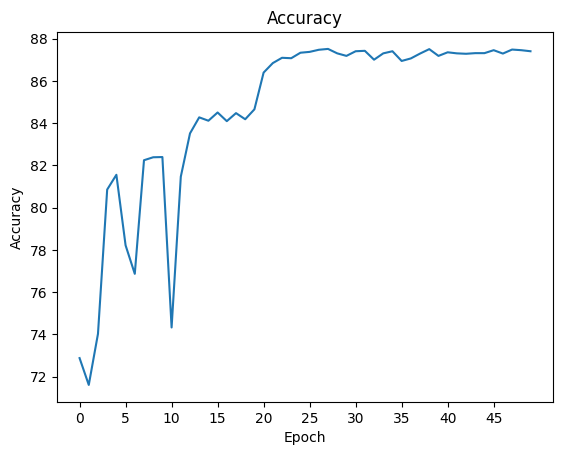

In [31]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

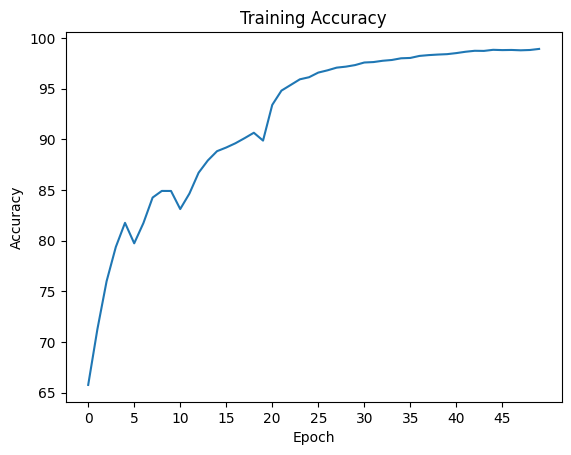

In [32]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

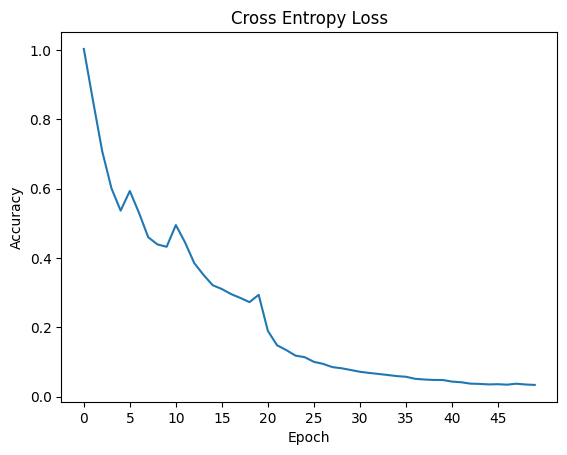

In [33]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()